# Comparación de Charts — Stamina RPG 7 (Nivel 16)

Este cuaderno compara tres charts del pack **Stamina RPG 7** con el mismo nivel de dificultad (16) para evidenciar cómo las métricas estructurales diferencian patterns de juego distintos:

| Chart | Archivo |
|---|---|
| Plasticworld (Easy) | `plasticworld.sm` |
| Holding Out For A Hero | `Holding Out For A Hero.sm` |
| ITC JAMS Vol 4 | `ITCJ4.sm` |

Se analizarán: densidad de notas por compás (NPS), secuencias de stream/break, breakdown notation y un cuadro comparativo de features.

## 1 · Setup: rutas, importaciones y configuración

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# ES: Importaciones estándar y configuración de sys.path para src/
# EN: Standard imports and sys.path configuration for src/

import sys
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "notebooks" else NOTEBOOK_DIR
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

DATA_ROOT = PROJECT_ROOT / "data" / "raw"

print(f"Project root : {PROJECT_ROOT}")
print(f"SRC path     : {SRC_PATH}")
print(f"Data root    : {DATA_ROOT}")

Project root : /home/maru/Documents/Tesina/ITGStamina-rater-ml/ml-core
SRC path     : /home/maru/Documents/Tesina/ITGStamina-rater-ml/ml-core/src
Data root    : /home/maru/Documents/Tesina/ITGStamina-rater-ml/ml-core/data/raw


In [3]:
# ES: Definición de los tres charts a comparar.
# EN: Definition of the three charts to compare.

CHARTS: dict[str, Path] = {
    "Plasticworld (Easy)": DATA_ROOT / "Stamina RPG 7" / "[16] Plasticworld (Easy)" / "plasticworld.sm",
    "Holding Out For A Hero": DATA_ROOT / "Stamina RPG 7" / "[16] Holding Out For A Hero" / "Holding Out For A Hero.sm",
    "ITC JAMS Vol 4": DATA_ROOT / "Stamina RPG 7" / "[16] ITC JAMS Vol 4" / "ITCJ4.sm",
}

# ES: Paleta de colores consistente para cada chart a lo largo de todo el notebook.
# EN: Consistent color palette for each chart throughout the notebook.
CHART_COLORS: dict[str, str] = {
    "Plasticworld (Easy)": "#3A86FF",
    "Holding Out For A Hero": "#FF5733",
    "ITC JAMS Vol 4": "#2ECC71",
}

# ES: Verificación de existencia de archivos.
# EN: File existence check.
for name, path in CHARTS.items():
    status = "✓" if path.exists() else "✗  MISSING"
    print(f"  {status}  {name}: {path.name}")

  ✓  Plasticworld (Easy): plasticworld.sm
  ✓  Holding Out For A Hero: Holding Out For A Hero.sm
  ✓  ITC JAMS Vol 4: ITCJ4.sm


## 2 · Parseo de los charts

In [4]:
# ES: Importar funciones de parseo y features desde src/
# EN: Import parsing and feature functions from src/

from parser import parse_sm_chart_with_meta
from features import (
    calculate_breakdown_metrics,
    generate_breakdown_string,
    get_stream_sequences,
    calculate_ebpm_profile,
)

# ES: Parsear los tres charts y almacenar sus datos en un diccionario.
# EN: Parse the three charts and store their data in a dictionary.

parsed: dict[str, dict] = {}

for chart_name, chart_path in CHARTS.items():
    notes_data, subdivision = parse_sm_chart_with_meta(chart_path)
    sequences = get_stream_sequences(notes_data["notes_per_measure"], subdivision=subdivision)
    metrics = calculate_breakdown_metrics(notes_data, subdivision=subdivision)
    breakdown = generate_breakdown_string(notes_data["notes_per_measure"], subdivision=subdivision)
    ebpm_profile = calculate_ebpm_profile(notes_data)

    parsed[chart_name] = {
        "notes_data": notes_data,
        "subdivision": subdivision,
        "sequences": sequences,
        "metrics": metrics,
        "breakdown": breakdown,
        "ebpm_profile": ebpm_profile,
        "path": chart_path,
    }

    print(f"  Parsed: {chart_name}")
    print(f"    Measures  : {len(notes_data['notes_per_measure'])}")
    print(f"    Display BPM: {notes_data['display_bpm']}")
    print(f"    Subdivision: {subdivision}")
    print(f"    Breakdown  : {breakdown}")
    print()

  Parsed: Plasticworld (Easy)
    Measures  : 250
    Display BPM: 174.0
    Subdivision: 16
    Breakdown  : 15 15 (2) 13 (2) 16 13 (3) 13 (2) 15 (17) 7 8 13 (2) 32 13 (2) 15

  Parsed: Holding Out For A Hero
    Measures  : 209
    Display BPM: 200.0
    Subdivision: 16
    Breakdown  : 7 7 8 (14) 2 (6) 1 (2) 47 14 (24) 1 39 8

  Parsed: ITC JAMS Vol 4
    Measures  : 1065
    Display BPM: 152.0
    Subdivision: 16
    Breakdown  : 3 (2) 7 13 (10) 4 (6) 1 7 6 (6) 131 31 11 3 11 3 15 24 (4) 12 (3) 4 30 (10) 15 (3) 11 (3) 20 2 (3) 1 3 12 (12) 7 7 40 (4) 5 1 20 11 (2) 2 (9) 6 15 (17) 15 15 3 1 1 1 15 42 (2) 21 8 4 1 7 2 (4) 2 (8) 24 8 (4) 3 5 7 3 3 7 9 (4) 3 (2) 5 1 (9) 7 7 7 7 15 (8) 4 2 3 (2) 3 (4) 4 (5) 3 1 1 2 (2) 7 7 15 (8) 4 2 (10) 1 1 2 3 (2) 3 (4) 8



## 3 · Gráficas de densidad (NPS por compás)

Se grafica la densidad de notas por segundo (NPS) para cada chart superpuesta en un único eje para comparación directa, seguida de tres subgráficas individuales que permiten apreciar el perfil de cada canción en detalle.

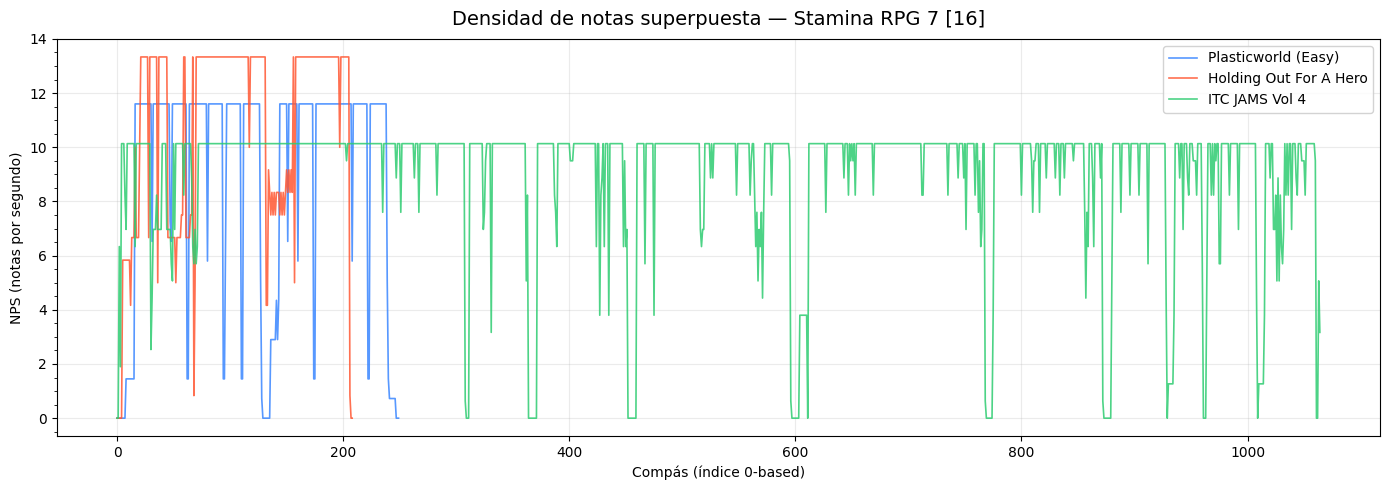

In [5]:
# ES: Función auxiliar: construye el vector NPS a partir de notes_data.
# EN: Helper: build NPS vector from notes_data.

def _nps_vector(notes_data: dict) -> list[float]:
    """ES: Devuelve NPS por compás; rellena con NaN si falta el BPM.

    EN: Return per-measure NPS; fills with NaN when BPM is missing.
    """
    bpm = notes_data.get("display_bpm")
    counts = notes_data["notes_per_measure"]
    if bpm and bpm > 0:
        sec = 240.0 / bpm
        return [c / sec for c in counts]
    return [float("nan")] * len(counts)


# ── Gráfica superpuesta ────────────────────────────────────────────────────────
fig_overlay, ax_overlay = plt.subplots(figsize=(14, 5))

for chart_name, data in parsed.items():
    nps = _nps_vector(data["notes_data"])
    color = CHART_COLORS[chart_name]
    ax_overlay.plot(
        range(len(nps)),
        nps,
        label=chart_name,
        color=color,
        linewidth=1.2,
        alpha=0.85,
    )

ax_overlay.set_title("Densidad de notas superpuesta — Stamina RPG 7 [16]", fontsize=14, pad=10)
ax_overlay.set_xlabel("Compás (índice 0-based)")
ax_overlay.set_ylabel("NPS (notas por segundo)")
ax_overlay.legend(loc="upper right", framealpha=0.85)
ax_overlay.grid(True, alpha=0.25)
ax_overlay.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.tight_layout()
plt.show()

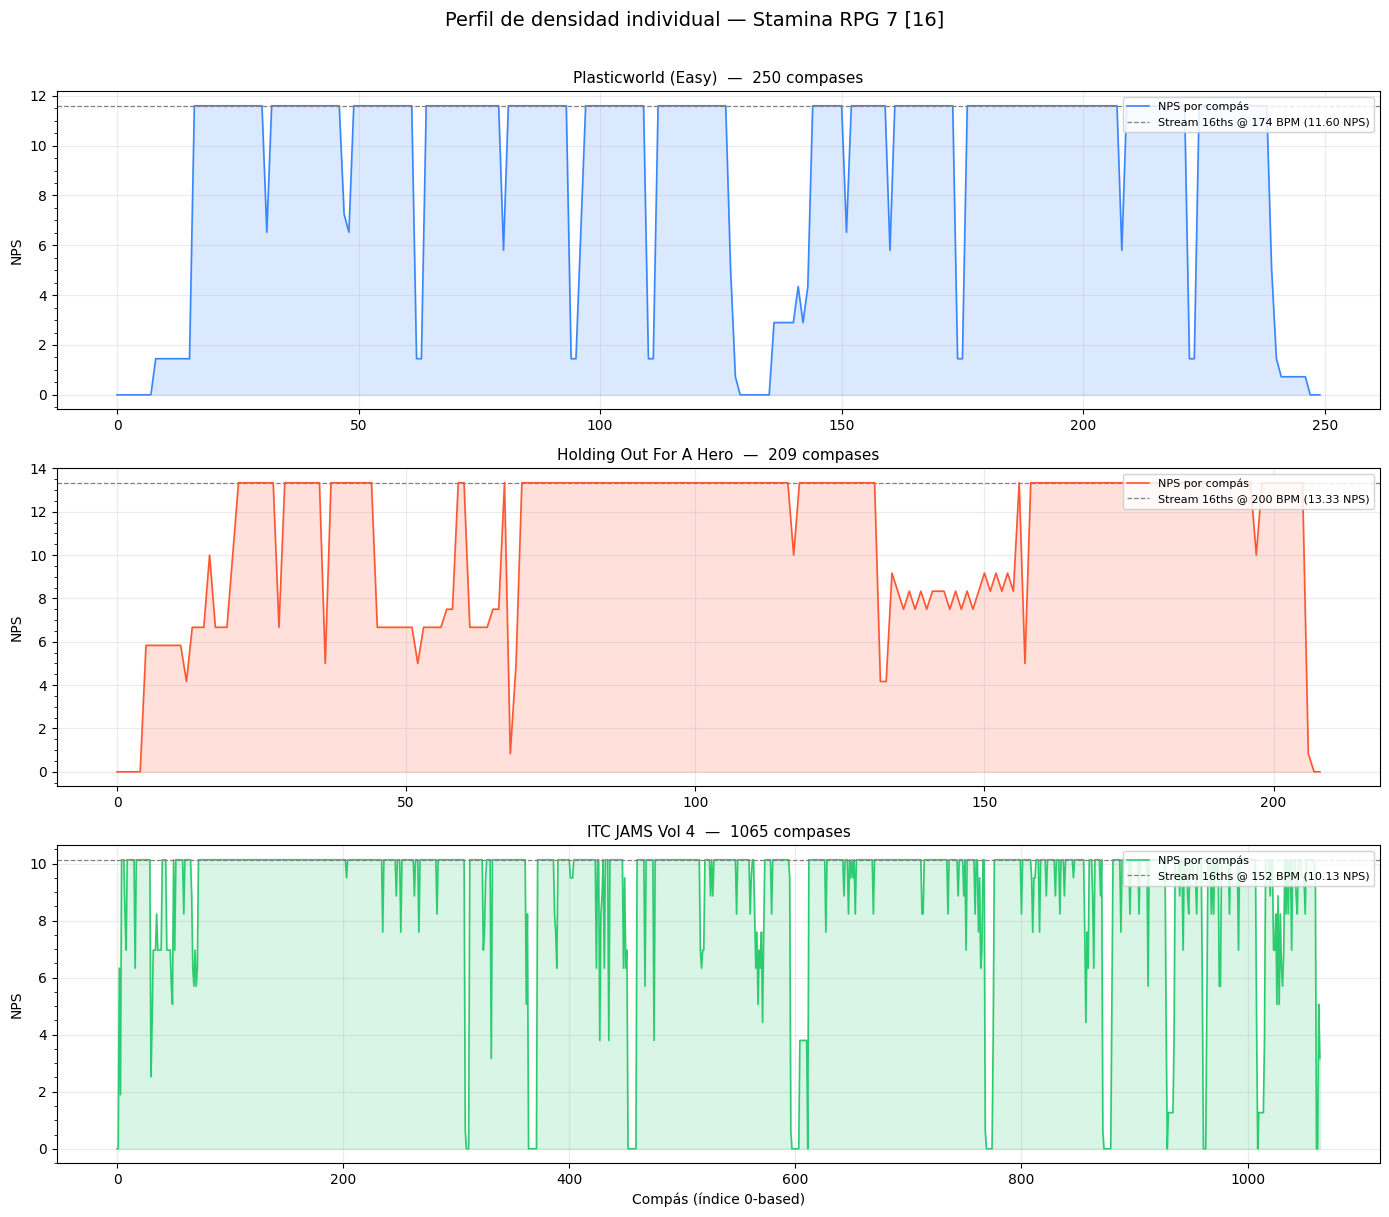

In [6]:
# ── Subgráficas individuales ───────────────────────────────────────────────────
# ES: Tres subplots en fila, uno por chart, con línea de BPM de referencia.
# EN: Three row subplots, one per chart, with a reference BPM line.

fig_grid, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False)

for ax, (chart_name, data) in zip(axes, parsed.items()):
    nps = _nps_vector(data["notes_data"])
    bpm = data["notes_data"].get("display_bpm")
    color = CHART_COLORS[chart_name]

    ax.fill_between(range(len(nps)), nps, alpha=0.18, color=color)
    ax.plot(range(len(nps)), nps, color=color, linewidth=1.2, label="NPS por compás")

    if bpm and bpm > 0:
        ref_nps = bpm / 15.0  # equivale a stream 16ths al BPM dado
        ax.axhline(
            ref_nps,
            color="gray",
            linestyle="--",
            linewidth=0.9,
            label=f"Stream 16ths @ {bpm:.0f} BPM ({ref_nps:.2f} NPS)",
        )

    ax.set_title(f"{chart_name}  —  {len(nps)} compases", fontsize=11)
    ax.set_ylabel("NPS")
    ax.legend(fontsize=8, loc="upper right", framealpha=0.85)
    ax.grid(True, alpha=0.25)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

axes[-1].set_xlabel("Compás (índice 0-based)")

fig_grid.suptitle(
    "Perfil de densidad individual — Stamina RPG 7 [16]",
    fontsize=14,
    y=1.01,
)
plt.tight_layout()
plt.show()

## 4 · Tabla de features comparativa

Se construye un `DataFrame` de pandas con las métricas extraídas de cada chart para facilitar la comparación numérica.

In [7]:
# ES: Construir DataFrame comparativo de features.
# EN: Build comparative features DataFrame.

rows = []
for chart_name, data in parsed.items():
    m = data["metrics"]
    nd = data["notes_data"]
    rows.append({
        "Chart": chart_name,
        "Display BPM": nd.get("display_bpm"),
        "eBPM": round(m["ebpm"], 1) if m["ebpm"] is not None else None,
        "Measures": len(nd["notes_per_measure"]),
        "Total Stream (comp.)": m["total_stream_length"],
        "Max Stream (comp.)": m["max_stream_length"],
        "Break Count": m["break_count"],
        "Stream/Break Ratio": round(m["stream_break_ratio"], 3) if m["stream_break_ratio"] != float("inf") else "∞",
        "Avg NPS": round(m["average_nps"], 3),
        "Subdivision": data["subdivision"],
    })

df_features = pd.DataFrame(rows).set_index("Chart")

print("=== Tabla comparativa de features ===")
print(df_features.to_string())

=== Tabla comparativa de features ===
                        Display BPM   eBPM  Measures  Total Stream (comp.)  Max Stream (comp.)  Break Count  Stream/Break Ratio  Avg NPS  Subdivision
Chart                                                                                                                                                
Plasticworld (Easy)           174.0  174.0       250                   188                  32            7               6.267    9.202           16
Holding Out For A Hero        200.0  200.0       209                   134                  47            4               2.913   10.813           16
ITC JAMS Vol 4                152.0  152.0      1065                   829                 131           31               4.820    9.069           16


In [8]:
# ES: Breakdown notation de cada chart para referencia rápida.
# EN: Breakdown notation per chart for quick reference.

print("=== Breakdown Notation ===")
for chart_name, data in parsed.items():
    print(f"\n{chart_name}:")
    print(f"  {data['breakdown']}")

=== Breakdown Notation ===

Plasticworld (Easy):
  15 15 (2) 13 (2) 16 13 (3) 13 (2) 15 (17) 7 8 13 (2) 32 13 (2) 15

Holding Out For A Hero:
  7 7 8 (14) 2 (6) 1 (2) 47 14 (24) 1 39 8

ITC JAMS Vol 4:
  3 (2) 7 13 (10) 4 (6) 1 7 6 (6) 131 31 11 3 11 3 15 24 (4) 12 (3) 4 30 (10) 15 (3) 11 (3) 20 2 (3) 1 3 12 (12) 7 7 40 (4) 5 1 20 11 (2) 2 (9) 6 15 (17) 15 15 3 1 1 1 15 42 (2) 21 8 4 1 7 2 (4) 2 (8) 24 8 (4) 3 5 7 3 3 7 9 (4) 3 (2) 5 1 (9) 7 7 7 7 15 (8) 4 2 3 (2) 3 (4) 4 (5) 3 1 1 2 (2) 7 7 15 (8) 4 2 (10) 1 1 2 3 (2) 3 (4) 8



## 5 · Comparación visual de features (barras)

Gráficas de barras para las métricas estructurales clave: longitud total de stream, stream máximo continuo, cantidad de breaks y ratio stream/break.

El **Ratio Stream/Break** se interpreta así:
- **Valor alto** → mucho más stream que break (chart continuo)
- **∞ (trama diagonal)** → sin breaks en absoluto (stream puro)
- **Valor bajo** → más break que stream (chart muy fragmentado)
- **1.0** → stream y break balanceados al 50 %


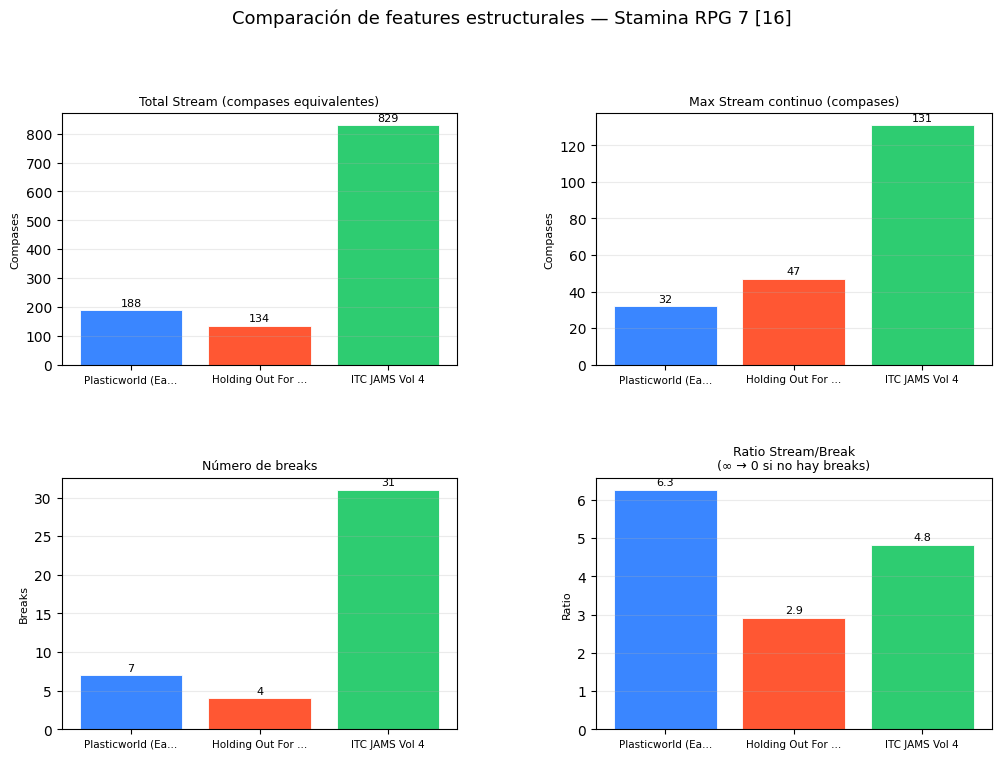

In [ ]:

# ES: Gráficas de barras comparativas para métricas estructurales clave.
#     eBPM se excluye aquí porque es un indicador de velocidad del chart
#     (Display BPM × multiplicador de subdivisión), no una feature estructural
#     que diferencie charts del mismo nivel.
# EN: Comparative bar charts for key structural metrics.
#     eBPM is excluded here because it is a chart speed indicator
#     (Display BPM × subdivision multiplier), not a structural feature
#     that differentiates same-level charts.

chart_names = list(parsed.keys())
colors = [CHART_COLORS[n] for n in chart_names]

# ES: Para el ratio Stream/Break, distinguimos los casos ∞ (sin breaks):
#     - La barra se dibuja al máximo de los valores finitos × 1.25 con trama.
#     - La etiqueta muestra "∞" en lugar de un número, para no confundir
#       ∞ con 0 ni con un ratio bajo.
# EN: For the Stream/Break ratio, we distinguish ∞ cases (no breaks):
#     - The bar is drawn at max(finite values) × 1.25 with a hatch pattern.
#     - The label shows "∞" instead of a number, to avoid confusion between
#       ∞ and 0 or a low ratio.
raw_ratios = [parsed[n]["metrics"]["stream_break_ratio"] for n in chart_names]
finite_ratios = [r for r in raw_ratios if r != float("inf")]
ratio_cap = (max(finite_ratios) * 1.25) if finite_ratios else 1.0
ratio_values = [ratio_cap if r == float("inf") else r for r in raw_ratios]
ratio_inf_mask = [r == float("inf") for r in raw_ratios]

metric_configs = [
    {
        "title": "Total Stream (compases equivalentes)",
        "values": [parsed[n]["metrics"]["total_stream_length"] for n in chart_names],
        "ylabel": "Compases",
    },
    {
        "title": "Max Stream continuo (compases)",
        "values": [parsed[n]["metrics"]["max_stream_length"] for n in chart_names],
        "ylabel": "Compases",
    },
    {
        "title": "Número de breaks",
        "values": [parsed[n]["metrics"]["break_count"] for n in chart_names],
        "ylabel": "Breaks",
    },
    {
        "title": "Ratio Stream/Break",
        "values": ratio_values,
        "ylabel": "Ratio",
        "note": "(↑ más stream · ∞ = sin breaks · ↓ más break)",
        "inf_mask": ratio_inf_mask,
    },
]

fig_bars, axes_bars = plt.subplots(
    2, 2, figsize=(12, 8), gridspec_kw={"hspace": 0.45, "wspace": 0.35}
)

for idx, ax in enumerate(axes_bars.flat):
    if idx >= len(metric_configs):
        ax.set_visible(False)
        continue

    cfg = metric_configs[idx]
    inf_mask = cfg.get("inf_mask", [False] * len(chart_names))

    bars = ax.bar(
        chart_names,
        cfg["values"],
        color=colors,
        edgecolor="white",
        linewidth=0.6,
    )

    # ES: Barras ∞ reciben trama diagonal para señalar que son un caso especial.
    # EN: ∞ bars get a diagonal hatch to signal they are a special case.
    for bar, is_inf in zip(bars, inf_mask):
        if is_inf:
            bar.set_hatch("///")
            bar.set_edgecolor("white")
            bar.set_linewidth(0.8)

    # ES: Etiqueta de valor encima de cada barra; "∞" para casos sin breaks.
    # EN: Value label above each bar; "∞" for no-break cases.
    for bar, val, is_inf in zip(bars, cfg["values"], inf_mask):
        label = "∞\n(sin breaks)" if is_inf else (
            f"{val:.1f}" if isinstance(val, float) else str(val)
        )
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(cfg["values"]) * 0.01,
            label,
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold" if is_inf else "normal",
        )

    title = cfg["title"]
    if "note" in cfg:
        title += f"\n{cfg['note']}"
    ax.set_title(title, fontsize=9, pad=6)
    ax.set_ylabel(cfg["ylabel"], fontsize=8)
    ax.set_xticks(range(len(chart_names)))
    ax.set_xticklabels(
        [n if len(n) <= 18 else n[:16] + "…" for n in chart_names],
        fontsize=7.5,
    )
    ax.grid(axis="y", alpha=0.25)
    ax.set_ylim(bottom=0)

fig_bars.suptitle(
    "Comparación de features estructurales — Stamina RPG 7 [16]",
    fontsize=13,
    y=1.01,
)
plt.savefig(PROJECT_ROOT / "notebooks" / "03_feature_bar_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figura guardada en notebooks/03_feature_bar_comparison.png")


## 6 · Distribución de longitudes de stream (box plot)

Un box plot por chart muestra la variación en longitudes de los segmentos de stream individuales, permitiendo ver si el chart es uniforme o tiene picos muy pronunciados.

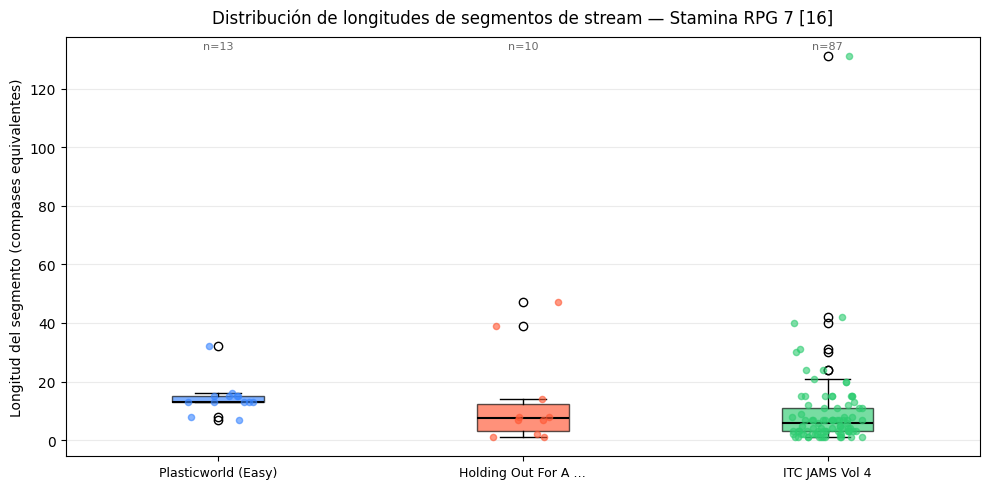

In [10]:
# ES: Box plot de longitudes de segmentos stream por chart.
# EN: Box plot of stream segment lengths per chart.

stream_len_data = []
stream_len_labels = []

for chart_name, data in parsed.items():
    lengths = [
        seg.get("scaled_length", seg["length"])
        for seg in data["sequences"]
        if not seg["is_break"]
    ]
    stream_len_data.append(lengths)
    stream_len_labels.append(chart_name)

fig_box, ax_box = plt.subplots(figsize=(10, 5))

bp = ax_box.boxplot(
    stream_len_data,
    tick_labels=stream_len_labels,
    patch_artist=True,
    medianprops={"color": "black", "linewidth": 1.5},
)

for patch, chart_name in zip(bp["boxes"], stream_len_labels):
    patch.set_facecolor(CHART_COLORS[chart_name])
    patch.set_alpha(0.65)

# ES: Superponer puntos individuales para ver distribución real.
# EN: Overlay individual points to see actual distribution.
for i, (lengths, chart_name) in enumerate(zip(stream_len_data, stream_len_labels), start=1):
    jitter = np.random.default_rng(42).uniform(-0.12, 0.12, len(lengths))
    ax_box.scatter(
        np.array([i] * len(lengths)) + jitter,
        lengths,
        color=CHART_COLORS[chart_name],
        s=20,
        alpha=0.6,
        zorder=3,
    )

    # ES: Anotar n=... encima de cada box.
    # EN: Annotate n=... above each box.
    ax_box.text(
        i,
        ax_box.get_ylim()[1] * 0.97,
        f"n={len(lengths)}",
        ha="center",
        fontsize=8,
        color="dimgray",
    )

ax_box.set_title(
    "Distribución de longitudes de segmentos de stream — Stamina RPG 7 [16]",
    fontsize=12,
    pad=10,
)
ax_box.set_ylabel("Longitud del segmento (compases equivalentes)")
ax_box.set_xticks(range(1, len(stream_len_labels) + 1))
ax_box.set_xticklabels(
    [n if len(n) <= 20 else n[:18] + "…" for n in stream_len_labels],
    fontsize=9,
)
ax_box.grid(axis="y", alpha=0.25)

plt.tight_layout()
plt.show()

## 7 · Perfil de eBPM por compás

Se dibuja la tasa efectiva de BPM (eBPM) compás a compás para los tres charts, resaltando las zonas de stream con un fondo coloreado.

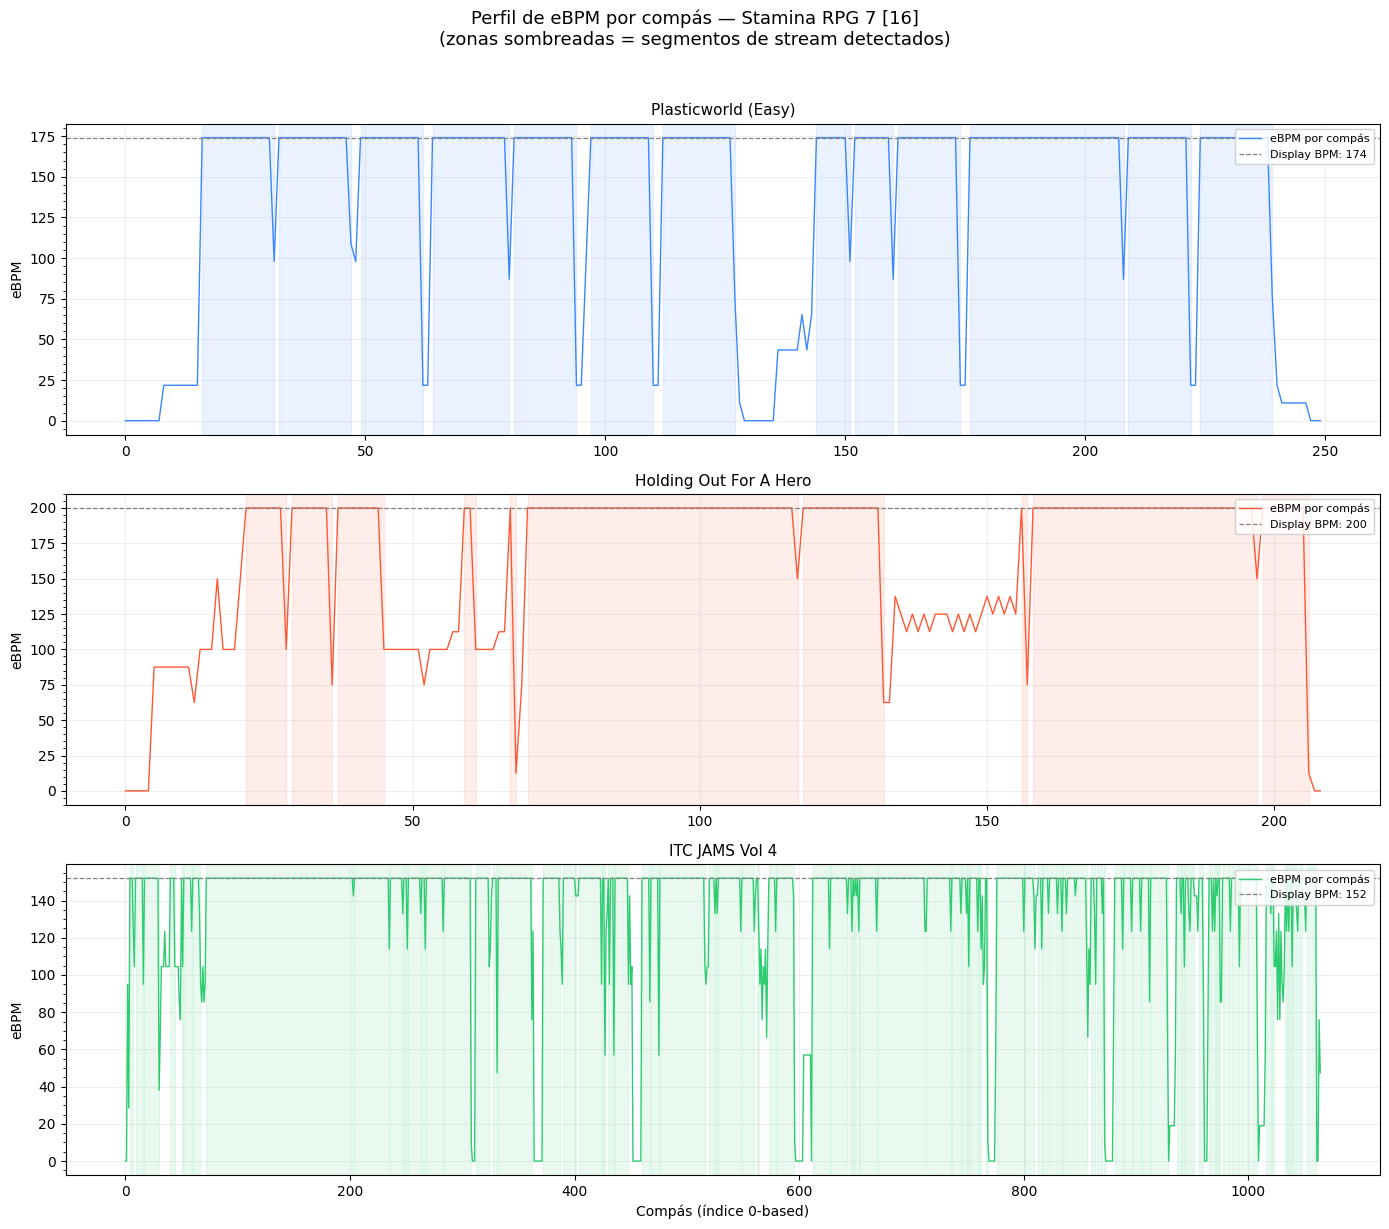

In [11]:
# ES: Gráfica de eBPM por compás para cada chart, con zonas de stream sombreadas.
# EN: Per-measure eBPM plot per chart with shaded stream zones.

fig_ebpm, axes_ebpm = plt.subplots(3, 1, figsize=(14, 12), sharex=False)

for ax, (chart_name, data) in zip(axes_ebpm, parsed.items()):
    ebpm_vals = data["ebpm_profile"].get("ebpm_per_measure", [])
    bpm = data["notes_data"].get("display_bpm")
    color = CHART_COLORS[chart_name]

    if ebpm_vals and ebpm_vals[0] is not None:
        # ES: Sombrear zonas de stream.
        # EN: Shade stream zones.
        for seg in data["sequences"]:
            if not seg["is_break"]:
                ax.axvspan(
                    seg["start"], seg["end"] + 1,
                    alpha=0.10,
                    color=color,
                    zorder=0,
                )

        ax.plot(
            range(len(ebpm_vals)),
            ebpm_vals,
            color=color,
            linewidth=1.0,
            label="eBPM por compás",
            zorder=2,
        )

        if bpm and bpm > 0:
            ax.axhline(
                bpm,
                color="gray",
                linestyle="--",
                linewidth=0.9,
                label=f"Display BPM: {bpm:.0f}",
            )
    else:
        ax.text(0.5, 0.5, "Sin BPM disponible", transform=ax.transAxes, ha="center")

    ax.set_title(f"{chart_name}", fontsize=11)
    ax.set_ylabel("eBPM")
    ax.legend(fontsize=8, loc="upper right", framealpha=0.85)
    ax.grid(True, alpha=0.20)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

axes_ebpm[-1].set_xlabel("Compás (índice 0-based)")

fig_ebpm.suptitle(
    "Perfil de eBPM por compás — Stamina RPG 7 [16]\n(zonas sombreadas = segmentos de stream detectados)",
    fontsize=13,
    y=1.02,
)
plt.tight_layout()
plt.show()

## 8 · Resumen textual final

In [12]:
# ES: Imprime un resumen comparativo final en texto plano para uso en la tesis.
# EN: Print a final comparative plain-text summary for use in the thesis.

separator = "=" * 70
print(separator)
print(" RESUMEN COMPARATIVO — Stamina RPG 7 [16]")
print(separator)

for chart_name, data in parsed.items():
    m = data["metrics"]
    nd = data["notes_data"]
    print(f"\n>>> {chart_name}")
    print(f"    Archivo       : {data['path'].name}")
    print(f"    Display BPM   : {nd.get('display_bpm')}")
    print(f"    eBPM          : {m['ebpm']:.1f}" if m["ebpm"] is not None else "    eBPM          : No disponible")
    print(f"    Subdivisión   : {data['subdivision']}")
    print(f"    Compases total: {len(nd['notes_per_measure'])}")
    print(f"    Breakdown     : {data['breakdown']}")
    print(f"    ── Métricas ──")
    print(f"    Total Stream  : {m['total_stream_length']} compases")
    print(f"    Max Stream    : {m['max_stream_length']} compases")
    print(f"    Break Count   : {m['break_count']}")
    ratio_str = (
        f"{m['stream_break_ratio']:.3f}"
        if m["stream_break_ratio"] != float("inf")
        else "∞ (sin breaks)"
    )
    print(f"    Stream/Break  : {ratio_str}")
    print(f"    Avg NPS       : {m['average_nps']:.3f}")

print(f"\n{separator}")

 RESUMEN COMPARATIVO — Stamina RPG 7 [16]

>>> Plasticworld (Easy)
    Archivo       : plasticworld.sm
    Display BPM   : 174.0
    eBPM          : 174.0
    Subdivisión   : 16
    Compases total: 250
    Breakdown     : 15 15 (2) 13 (2) 16 13 (3) 13 (2) 15 (17) 7 8 13 (2) 32 13 (2) 15
    ── Métricas ──
    Total Stream  : 188 compases
    Max Stream    : 32 compases
    Break Count   : 7
    Stream/Break  : 6.267
    Avg NPS       : 9.202

>>> Holding Out For A Hero
    Archivo       : Holding Out For A Hero.sm
    Display BPM   : 200.0
    eBPM          : 200.0
    Subdivisión   : 16
    Compases total: 209
    Breakdown     : 7 7 8 (14) 2 (6) 1 (2) 47 14 (24) 1 39 8
    ── Métricas ──
    Total Stream  : 134 compases
    Max Stream    : 47 compases
    Break Count   : 4
    Stream/Break  : 2.913
    Avg NPS       : 10.813

>>> ITC JAMS Vol 4
    Archivo       : ITCJ4.sm
    Display BPM   : 152.0
    eBPM          : 152.0
    Subdivisión   : 16
    Compases total: 1065
    Breakdow